# Домашнее задание № 8

## Задание 1 (4 балла) 

Обучите 8 моделей для задачи классификации текста (датасет - lenta_40k ). А именно:  
1) модель с 1 GRU слоем;   
2) модель с 1 LSTM слоем    
3) модель с 1 GRU и 1 LSTM слоем  
4) модель с 1 BIGRU и 2 LSTM слоями  
5) модель с 5 GRU слоями и 3 LSTM слоями  
6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались   
7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM  
8) модель с 50 любыми рекуррентными слоями  


Параметр units и размер эмбединга можете задать любой. Оцените качество каждой модели и определите победителя.

In [1]:
!pip install gensim --upgrade

     |████████████████████████████████| 24.1 MB 1.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [2]:
import tensorflow as tf

In [3]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
!wget https://github.com/mannefedov/compling_nlp_hse_course/raw/master/notebooks/rnn_ner/lenta_40k.csv.zip

--2022-03-02 13:08:24--  https://github.com/mannefedov/compling_nlp_hse_course/raw/master/notebooks/rnn_ner/lenta_40k.csv.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/notebooks/rnn_ner/lenta_40k.csv.zip [following]
--2022-03-02 13:08:24--  https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/notebooks/rnn_ner/lenta_40k.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30658975 (29M) [application/zip]
Saving to: ‘lenta_40k.csv.zip’

lenta_40k.csv.zip   100%[===================>]  29.24M  --.-KB/s    in 0.1s    

2022-03

In [5]:
data = pd.read_csv('lenta_40k.csv.zip')

In [6]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [7]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [8]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [9]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [10]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [11]:
id2word = {i:word for word, i in word2id.items()}

In [12]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [13]:
MEAN_LEN = np.median([len(x) for x in X])

In [14]:
MAX_LEN = int(MEAN_LEN + 30)

In [15]:
# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [16]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [17]:
y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

In [19]:
import random

def make_random_model():
  models = {
      0: tf.keras.layers.GRU,
      1: tf.keras.layers.LSTM,
      #2: (tf.keras.layers.Bidirectional, [tf.keras.layers.LSTM]),
      #3: (tf.keras.layers.Bidirectional, [tf.keras.layers.GRU]),
      #4: (tf.keras.layers.Bidirectional, [tf.keras.layers.GRU, tf.keras.layers.LSTM]),
      #5: (tf.keras.layers.Bidirectional, [tf.keras.layers.LSTM, tf.keras.layers.GRU]),
      #6: (tf.keras.layers.Bidirectional, [tf.keras.layers.GRU, tf.keras.layers.GRU]),
      #7: (tf.keras.layers.Bidirectional, [tf.keras.layers.LSTM, tf.keras.layers.LSTM])
  }
  model_index = random.randint(0, len(models) - 1)
  return models[model_index]

In [20]:
tasks = {
    '1': [tf.keras.layers.GRU],
    '2': [tf.keras.layers.LSTM],
    '3': [tf.keras.layers.GRU, tf.keras.layers.LSTM],
    '4': [(tf.keras.layers.Bidirectional, [tf.keras.layers.LSTM])] + [tf.keras.layers.LSTM] * 2,
    '5': [tf.keras.layers.GRU] * 5 + [tf.keras.layers.LSTM] * 3,
    '6': [(tf.keras.layers.Bidirectional, [tf.keras.layers.GRU, tf.keras.layers.LSTM]), (tf.keras.layers.Bidirectional, [tf.keras.layers.LSTM, tf.keras.layers.GRU])],
    '7': [tf.keras.layers.LSTM, tf.keras.layers.GRU, (tf.keras.layers.Bidirectional, [tf.keras.layers.LSTM]),
                                             (tf.keras.layers.Bidirectional, [tf.keras.layers.GRU]), tf.keras.layers.GRU, tf.keras.layers.LSTM],
    '8': [make_random_model() for i in range(50)],
}

In [21]:
def show_model(model):
  print(model.history.history.keys())
  # summarize history for accuracy
  plt.plot(model.history.history['f1'])
  plt.plot(model.history.history['val_f1'])
  plt.title('model f1')
  plt.ylabel('f1')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [22]:
def make_model(layers, len_vocab, len_labels):
  sequences = len(layers) > 1

  inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
  embeddings = tf.keras.layers.Embedding(input_dim=len_vocab, output_dim=60)(inputs, )

  rnns = [embeddings]

  for i, layer in enumerate(layers):
    if type(layer) is tuple:
      bi = layer[0]
      bi_layers = layer[1]
      forward = bi_layers[0]
      backward = bi_layers[1] if len(bi_layers) == 2 else None
      if backward == None:
        rnn = bi(forward(256, return_sequences=sequences))(rnns[i])
      else:
        rnn = bi(forward(256, return_sequences=sequences),
                 backward_layer=backward(256, return_sequences=sequences, go_backwards=True))(rnns[i])
    else:
      rnn = layer(256, return_sequences=sequences)(rnns[i])
    rnns.append(rnn)
    sequences = i != len(layers) - 2
  
  dense = rnns[-1]
  if len(layers) > 1:
    dense = tf.keras.layers.Dense(64, activation='relu')(dense)
  # rnn = tf.keras.layers.SimpleRNN(128, return_sequences=False)(embeddings)
  #rnn = tf.keras.layers.LSTM(128, return_sequences=False)(embeddings)
  #rnn = tf.keras.layers.GRU(128, return_sequences=False)(embeddings)

  outputs = tf.keras.layers.Dense(len_labels, activation='softmax')(dense)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])
  
  return model

In [23]:
models = [make_model(model, len(word2id), len(label2id)) for model in tasks.values()]

In [24]:
for i, model in enumerate(models[:4]):
  model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          epochs=15)

Epoch 1/15
43/43 [==============================] - 21s 313ms/step - loss: 2.4544 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.2623 - val_f1: 0.0000e+00 - val_rec@prec: 0.0018
Epoch 2/15
43/43 [==============================] - 13s 293ms/step - loss: 2.2665 - f1: 0.0059 - rec@prec: 0.0000e+00 - val_loss: 2.1643 - val_f1: 0.0000e+00 - val_rec@prec: 0.0036
Epoch 3/15
43/43 [==============================] - 13s 297ms/step - loss: 1.9612 - f1: 0.0799 - rec@prec: 0.0203 - val_loss: 1.8215 - val_f1: 0.1225 - val_rec@prec: 0.0491
Epoch 4/15
43/43 [==============================] - 13s 297ms/step - loss: 1.5543 - f1: 0.3271 - rec@prec: 0.1581 - val_loss: 1.5508 - val_f1: 0.3706 - val_rec@prec: 0.1727
Epoch 5/15
43/43 [==============================] - 13s 299ms/step - loss: 1.3056 - f1: 0.4830 - rec@prec: 0.3096 - val_loss: 1.5906 - val_f1: 0.4242 - val_rec@prec: 0.1826
Epoch 6/15
43/43 [==============================] - 13s 301ms/step - loss: 1.0907 - f1: 0.5989 - rec@prec: 0.4905 -

In [25]:
models[4].fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=15)

Epoch 1/15
83/83 [==============================] - 153s 2s/step - loss: 2.3635 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3238 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/15
83/83 [==============================] - 137s 2s/step - loss: 2.3258 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3250 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/15
83/83 [==============================] - 137s 2s/step - loss: 2.3244 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3224 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 4/15
83/83 [==============================] - 137s 2s/step - loss: 2.3236 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3189 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 5/15
83/83 [==============================] - 137s 2s/step - loss: 2.3232 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3209 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 6/15
83/83 [==============================] - 137s 2s/step 

In [26]:
models[5].fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          epochs=15)

Epoch 1/15
43/43 [==============================] - 80s 2s/step - loss: 2.4303 - f1: 0.0037 - rec@prec: 0.0000e+00 - val_loss: 2.2831 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/15
43/43 [==============================] - 72s 2s/step - loss: 2.0450 - f1: 0.0342 - rec@prec: 0.0074 - val_loss: 1.8020 - val_f1: 0.1166 - val_rec@prec: 0.0667
Epoch 3/15
43/43 [==============================] - 72s 2s/step - loss: 1.6083 - f1: 0.2356 - rec@prec: 0.1218 - val_loss: 1.5606 - val_f1: 0.3544 - val_rec@prec: 0.1718
Epoch 4/15
43/43 [==============================] - 72s 2s/step - loss: 1.3443 - f1: 0.4144 - rec@prec: 0.2387 - val_loss: 1.4976 - val_f1: 0.4177 - val_rec@prec: 0.2024
Epoch 5/15
43/43 [==============================] - 72s 2s/step - loss: 1.1021 - f1: 0.5891 - rec@prec: 0.4228 - val_loss: 1.2554 - val_f1: 0.5959 - val_rec@prec: 0.4405
Epoch 6/15
43/43 [==============================] - 72s 2s/step - loss: 0.8524 - f1: 0.7237 - rec@prec: 0.6748 - val_loss: 1.1774 - val_f1

In [27]:
models[6].fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
          epochs=15)

Epoch 1/15
83/83 [==============================] - 170s 2s/step - loss: 2.3458 - f1: 0.0022 - rec@prec: 0.0000e+00 - val_loss: 2.0372 - val_f1: 0.0498 - val_rec@prec: 0.0311
Epoch 2/15
83/83 [==============================] - 155s 2s/step - loss: 1.8150 - f1: 0.1301 - rec@prec: 0.0746 - val_loss: 1.7553 - val_f1: 0.1431 - val_rec@prec: 0.0969
Epoch 3/15
83/83 [==============================] - 155s 2s/step - loss: 1.6122 - f1: 0.2828 - rec@prec: 0.1204 - val_loss: 1.7528 - val_f1: 0.2511 - val_rec@prec: 0.1118
Epoch 4/15
83/83 [==============================] - 155s 2s/step - loss: 1.4307 - f1: 0.4528 - rec@prec: 0.1842 - val_loss: 1.4634 - val_f1: 0.4984 - val_rec@prec: 0.1767
Epoch 5/15
83/83 [==============================] - 155s 2s/step - loss: 1.1739 - f1: 0.6019 - rec@prec: 0.4034 - val_loss: 1.3056 - val_f1: 0.5663 - val_rec@prec: 0.3981
Epoch 6/15
83/83 [==============================] - 155s 2s/step - loss: 0.9983 - f1: 0.6822 - rec@prec: 0.5914 - val_loss: 1.2115 - val_f1: 

In [28]:
models[7].fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=96,
          epochs=20)

Epoch 1/20
439/439 [==============================] - 1822s 4s/step - loss: 2.3400 - f1: 5.4575e-04 - rec@prec: 0.0000e+00 - val_loss: 2.3290 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
439/439 [==============================] - 1729s 4s/step - loss: 2.3262 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3202 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/20
439/439 [==============================] - 1723s 4s/step - loss: 2.3253 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3215 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 4/20
439/439 [==============================] - 1726s 4s/step - loss: 2.3246 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3213 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 5/20
439/439 [==============================] - 1728s 4s/step - loss: 2.3238 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3189 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 6/20
123/439 [=======>......................

KeyboardInterrupt: ignored

Task 1
dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


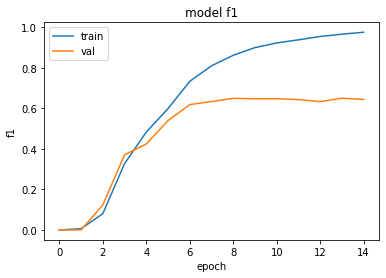

Task 2
dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


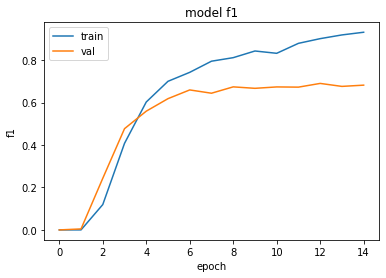

Task 3
dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


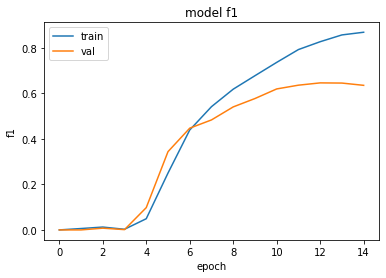

Task 4
dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


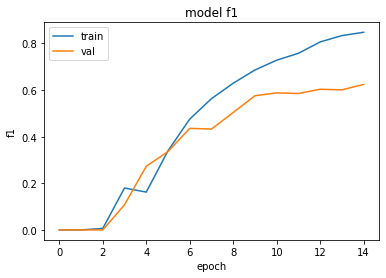

Task 5
dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


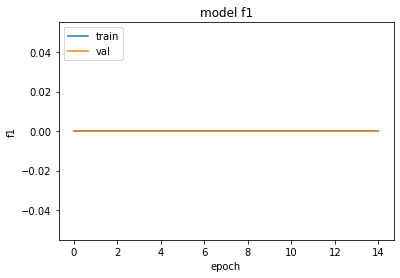

Task 6
dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


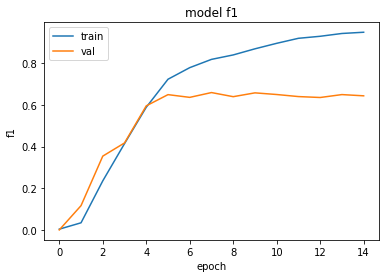

Task 7
dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


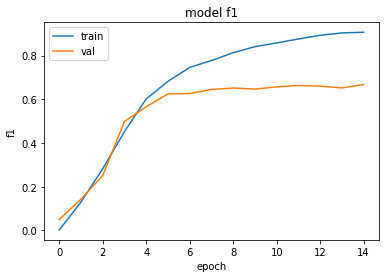

Task 8
dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


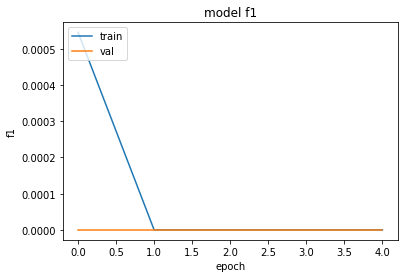

In [29]:
for i, model in enumerate(models):
  print(f'Task {i+1}')
  show_model(model)

В целом модели показывают себя одинаково, потому выбирать лучшую из них стоит исходя из показателей скорости обучения. По этому параметру лучше всего показала себя модель, состоящая либо из LSTM, либо GRU слоя. Модели с большим количеством слоёв обучаются сильно долго и дают при этом почти такой же результат, как и простые модели.

Стоит отметить, что модель из 5 задания иногда даёт результаты, а иногда нет, как это случилось в текущей сессии. Вдобавок модель из последнего задания обучалась слишком долго, потому было решено остановить обучение.

## Задание 2 (6 баллов)


На данных википедии (wikiann) обучите 2 модели:  
1) модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев. 

2) модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев. 

Сравните качество по метрикам. Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset("wikiann", 'ru')

Reusing dataset wikiann (/root/.cache/huggingface/datasets/wikiann/ru/1.1.0/4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
import gensim

In [ ]:
def calculate_weights(word2id, len_dim, embeddings):
  weights = np.zeros((len(word2id), len_dim))

  for word, i in word2id.items():
      # вектор паддинга оставим нулевым
      if word in ['PAD', 'UNK']:
          continue

      try:
          weights[i] = embeddings[word]
      
      
      except KeyError:
          # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
          continue
          weights[i] = embeddings['опрагпллирао']

  return weights

In [ ]:
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

In [ ]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)

In [ ]:
w2v = gensim.models.Word2Vec([[y.lower() for y in x] for x in dataset['train']['tokens']], 
                             vector_size=500, 
                             min_count=50, 
                             window=8,
                             sg=1,
                             workers=2,
                             seed=2,
                             epochs=7,
                             )

In [ ]:
weights = calculate_weights(word2id, 500, w2v.wv)

In [ ]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
# переводим тексты в последовательности индексов
X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [ ]:
# переводим тексты в последовательности индексов
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [ ]:
MAX_LEN = max(len(x) for x in X)

# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

In [ ]:
id2labels = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6:'I-LOC', 7:'PAD'}
label2id = {v:k for k,v in id2labels.items()} 

In [ ]:
y = tf.keras.preprocessing.sequence.pad_sequences(dataset['train']['ner_tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = tf.keras.preprocessing.sequence.pad_sequences(dataset['test']['ner_tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

In [ ]:
def fit_seq_model(model, len_dim, len_labels, weights):
  inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

  embeddings = tf.keras.layers.Embedding(input_dim=len_dim, output_dim=500, 
                                        trainable=False,
                                        weights=[weights]
                                         )(inputs, )

  layers = [embeddings]

  for i in range(5):
    lstm = tf.keras.layers.Bidirectional(model)(layers[i])
    layers.append(lstm)

  outputs = tf.keras.layers.Dense(len_labels, activation='softmax')(layers[-1])

  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
  
  return model

In [ ]:
models = [fit_seq_model(tf.keras.layers.LSTM(256, return_sequences=True), len(word2id), len(label2id), weights), 
          fit_seq_model(tf.keras.layers.GRU(256, return_sequences=True), len(word2id), len(label2id), weights)
]

In [ ]:
for model in models:
  model.fit(X, y, 
            validation_data=(X_test, y_test),
            batch_size=256,
          epochs=5)

Epoch 1/5
79/79 [==============================] - 64s 594ms/step - loss: 0.2897 - accuracy: 0.9170 - val_loss: 0.1662 - val_accuracy: 0.9504
Epoch 2/5
79/79 [==============================] - 42s 539ms/step - loss: 0.1524 - accuracy: 0.9529 - val_loss: 0.1463 - val_accuracy: 0.9538
Epoch 3/5
79/79 [==============================] - 42s 538ms/step - loss: 0.1334 - accuracy: 0.9576 - val_loss: 0.1304 - val_accuracy: 0.9585
Epoch 4/5
79/79 [==============================] - 42s 537ms/step - loss: 0.1199 - accuracy: 0.9623 - val_loss: 0.1184 - val_accuracy: 0.9619
Epoch 5/5
79/79 [==============================] - 42s 537ms/step - loss: 0.1112 - accuracy: 0.9650 - val_loss: 0.1075 - val_accuracy: 0.9656
Epoch 1/5
79/79 [==============================] - 58s 508ms/step - loss: 0.2495 - accuracy: 0.9331 - val_loss: 0.1337 - val_accuracy: 0.9548
Epoch 2/5
79/79 [==============================] - 36s 459ms/step - loss: 0.1143 - accuracy: 0.9616 - val_loss: 0.1016 - val_accuracy: 0.9674
Epoch 

In [ ]:
def seq_show_model(model):
  print(model.history.history.keys())
  plt.plot(model.history.history['accuracy'])
  plt.plot(model.history.history['val_accuracy'])
  plt.title('model acc')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

Task LSTM
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


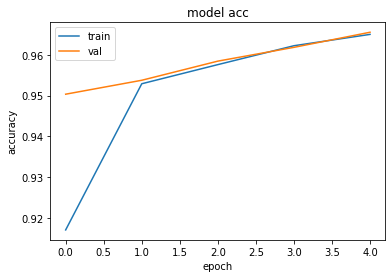

Task GRU
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


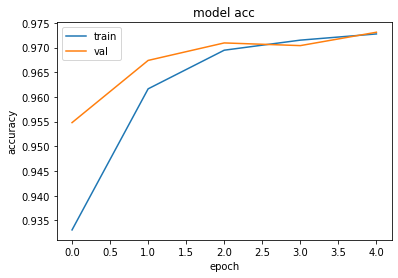

In [ ]:
n_models = ['LSTM', 'GRU']

for i, model in enumerate(models):
  print(f'Task {n_models[i]}')
  seq_show_model(model)

In [ ]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(tf.keras.preprocessing.sequence.pad_sequences([ids], 
                                                                       maxlen=max_len, 
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))
    
    return list(zip(tokens, labels))

In [ ]:
from pprint import pprint

def compare_models(sentence, models, word2id, id2labels):
  for i, model in enumerate(models):
    print(f'Model {n_models[i]}')
    pprint(label_seq(sentence, word2id, id2labels, MAX_LEN, model))

In [ ]:
compare_models('Пётр Петрович Петров сказал Василию Ивановичу об отъезде в Карловы Вары.', models, word2id, id2labels)

Model LSTM
[('Пётр', 'O'),
 ('Петрович', 'O'),
 ('Петров', 'O'),
 ('сказал', 'O'),
 ('Василию', 'O'),
 ('Ивановичу', 'O'),
 ('об', 'O'),
 ('отъезде', 'O'),
 ('в', 'O'),
 ('Карловы', 'O'),
 ('Вары', 'I-ORG'),
 ('.', 'O')]
Model GRU
[('Пётр', 'O'),
 ('Петрович', 'O'),
 ('Петров', 'O'),
 ('сказал', 'O'),
 ('Василию', 'O'),
 ('Ивановичу', 'O'),
 ('об', 'O'),
 ('отъезде', 'O'),
 ('в', 'O'),
 ('Карловы', 'B-ORG'),
 ('Вары', 'I-ORG'),
 ('.', 'O')]


In [ ]:
compare_models('Москвой Иван был потрясён.', models, word2id, id2labels)

Model LSTM
[('Москвой', 'O'),
 ('Иван', 'O'),
 ('был', 'O'),
 ('потрясён', 'B-LOC'),
 ('.', 'O')]
Model GRU
[('Москвой', 'O'),
 ('Иван', 'O'),
 ('был', 'O'),
 ('потрясён', 'B-LOC'),
 ('.', 'O')]


In [ ]:
compare_models('Иван был потрясён Москвой.', models, word2id, id2labels)

Model LSTM
[('Иван', 'O'),
 ('был', 'O'),
 ('потрясён', 'O'),
 ('Москвой', 'B-LOC'),
 ('.', 'O')]
Model GRU
[('Иван', 'O'),
 ('был', 'O'),
 ('потрясён', 'B-ORG'),
 ('Москвой', 'I-ORG'),
 ('.', 'O')]


In [ ]:
compare_models('Ты к нам в Москву приезжай и пройдись по Арбату, окунись на Тверском в шум зеленых аллей, хотя бы раз посмотри, как танцуют девчата на ладонях больших голубых площадей!.', models, word2id, id2labels)

Model LSTM
[('Ты', 'O'),
 ('к', 'O'),
 ('нам', 'O'),
 ('в', 'O'),
 ('Москву', 'O'),
 ('приезжай', 'O'),
 ('и', 'O'),
 ('пройдись', 'O'),
 ('по', 'O'),
 ('Арбату', 'O'),
 (',', 'O'),
 ('окунись', 'O'),
 ('на', 'O'),
 ('Тверском', 'O'),
 ('в', 'O'),
 ('шум', 'O'),
 ('зеленых', 'O'),
 ('аллей', 'O'),
 (',', 'O'),
 ('хотя', 'O'),
 ('бы', 'O'),
 ('раз', 'O'),
 ('посмотри', 'O'),
 (',', 'O'),
 ('как', 'O'),
 ('танцуют', 'O'),
 ('девчата', 'O'),
 ('на', 'O'),
 ('ладонях', 'O'),
 ('больших', 'PAD'),
 ('голубых', 'PAD'),
 ('площадей', 'PAD'),
 ('!.', 'PAD')]
Model GRU
[('Ты', 'O'),
 ('к', 'O'),
 ('нам', 'O'),
 ('в', 'O'),
 ('Москву', 'O'),
 ('приезжай', 'O'),
 ('и', 'O'),
 ('пройдись', 'O'),
 ('по', 'O'),
 ('Арбату', 'I-ORG'),
 (',', 'O'),
 ('окунись', 'O'),
 ('на', 'O'),
 ('Тверском', 'O'),
 ('в', 'O'),
 ('шум', 'O'),
 ('зеленых', 'O'),
 ('аллей', 'I-ORG'),
 (',', 'O'),
 ('хотя', 'O'),
 ('бы', 'O'),
 ('раз', 'O'),
 ('посмотри', 'I-ORG'),
 (',', 'O'),
 ('как', 'O'),
 ('танцуют', 'O'),
 ('девчат

Видно, что на примерах модели работают очень плохо, но при этом результаты у GRU-модели лучше, чем у LSTM. Ещё стоит отметить, что качество определения сущностей зависит от расположения слов в предложении.